<a href="https://colab.research.google.com/github/viswambhar-yasa/AuToDiFf/blob/main/derivative_of_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

!git clone https://github.com/viswambhar-yasa/AuToDiFf "/content/drive/My Drive/AutoDiff"

Mounted at /content/drive
fatal: destination path '/content/drive/My Drive/AutoDiff' already exists and is not an empty directory.


In [4]:
ls

drive/  sample_data/


In [5]:
import sys,os
sys.path.append('/content/drive/MyDrive/AutoDiff/')

In [6]:
ls

drive/  sample_data/


In [7]:
cd /content/drive/MyDrive/AutoDiff/

/content/drive/MyDrive/AutoDiff


In [8]:
import autodiff as ad 
import numpy as np
from NN_architecture import NeuralNetLSTM,xavier,diff_n_times
import matplotlib.pyplot as plt 
from optimizers import *

In [9]:
def loss(model,point):
    """
    Calculates loss of a model at the given point 
    Inputs:
    model: The NN model which is being trained .Type: Neural Net LSTM Object. 
    point: The point at which the loss is to be calculated. Type:Float
    returns: squared loss of model at the point
    """
    #Conversion of the point into autodiff variable
    point = ad.Variable(np.array([[point]]),name="point")
    val = model.output(point)
    #penalizing against sine
    loss = val - ad.Sine(point)

    return ad.Pow(loss,2)

def sampler(n):
    """
    samples of random data points(uniformly distributed)
    inputs:
    n : number of data points

    returns array of size n  
    """
    return np.random.uniform(0,np.pi,n) 

#Instantiating the Neural Network
model = NeuralNetLSTM(5,1,1,1)
model.set_weights([xavier(i().shape[0],i().shape[1]) for i in model.get_weights()])
listx= sampler(500)
#print(listx)
#Max number of iterations
epochs = 50
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [11]:
#training the model
loss_model=[]

for j in range(epochs):
    #Instantiating optimizer
    with HiddenPrints():
      optimizer = RMSProp(len(model.get_weights()))
      L1 = ad.Variable(0,"L1")
      for i in listx:
        L1.value = L1.value + loss(model,i)()[0][0]
    #print("initial loss",L1())
      for i in listx:
        params = model.get_weights()
        #Get Gradients

        grad_params = ad.grad(loss(model,i),params)
        new_params=[0 for _ in params]

        #Take descent step by calling optimizer
        new_params = optimizer([i() for i in params], [i() for i in grad_params])
        
        model.set_weights(new_params)

      L2 = ad.Variable(0,"L2")
      for i in listx:
        L2.value = L2.value + loss(model,i)()[0][0]
    #Exit condition
    if L2() > L1() or L2() < 1e-2: #or np.abs(L2()-L1()) < 1e-2:
        print("iteration",j,"loss:",L2())
        break
    else:
        print("gradient steptaken epoch:",j)



gradient steptaken epoch: 0
gradient steptaken epoch: 1
gradient steptaken epoch: 2
iteration 3 loss: 0.09439647585467947


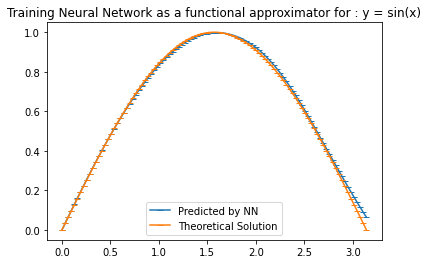

In [12]:
x_list = np.linspace(0,np.pi,100)
def y(x):
    """
    sin function for plotting 
    input:
    x : float or numpy array of floats
    returns sin(x)
    """
    return np.sin(x)
y_list =[]
for i in x_list:
    X=ad.Variable(np.array([[i]]),name="X")
    y_list.append(model.output(X)()[0][0])
plt.plot(x_list,y_list,marker="_",label="Predicted by NN")
plt.plot(x_list,y(x_list),marker="_",label="Theoretical Solution")
plt.title("Training Neural Network as a functional approximator for : y = sin(x)")
plt.legend()
plt.show()